In [1]:
import os
from itertools import chain
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import utils
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, GlobalAveragePooling2D, LSTM, TimeDistributed, Dropout, Dense, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator, array_to_img
import numpy as np
from PIL import Image
from tqdm import tqdm
from tqdm.keras import TqdmCallback
import pandas as pd
import math
import matplotlib.pyplot as plt
import shutil
from collections import defaultdict
from sklearn.model_selection import train_test_split
import pandas as pd

from data import Data

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
LABEL_INDEX = {
    'ap': 0,
    'bs': 1,
    'mid': 2,
    'oap': 3,
    'obs': 4,
}

In [4]:
keras_app = tf.keras.applications.mobilenet
keras_model = tf.keras.applications.mobilenet.MobileNet
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rescale=1,
    fill_mode="nearest",
    preprocessing_function=keras_app.preprocess_input)
datagen = ImageDataGenerator(preprocessing_function=keras_app.preprocess_input)

In [5]:
class PhaseDataGenerator(keras.utils.Sequence):
    def __init__(self, data: Data, datasets=None, batch_size=32, target_size=(224, 224), 
                 slices_per_sample=25, shuffle=True, image_data_generator=None):
        self.data = data
        self.datasets = datasets
        self.batch_size = batch_size
        self.target_size=  target_size
        self.slices_per_sample = slices_per_sample
        self.shuffle = shuffle
        self.datagen = image_data_generator
        
        self.n_classes = 5
        self.label_indices = LABEL_INDEX

        self.samples = dict()
        self.max_slices = 1
        
        if datasets is None:
            datasets = list(data.data.keys())
        if isinstance(datasets, str):
            datasets = [datasets]
        
        # All plural variables are dicts
        for dataset in datasets:
            for patient, phases in data.data[dataset].items():
                for phase, slices in phases.items():
                    key = "{dataset}_{patient:06d}_{slice:02d}".format(dataset=dataset, patient=patient, slice=phase)
                    self.samples[key] = slices
                    if len(slices) > self.max_slices:
                        self.max_slices = len(slices)
        
        if slices_per_sample < self.max_slices:
            raise ValueError("There are some samples that contain more than {} slices ({})".format(
                slices_per_sample, self.max_slices))
        
        unlabeled = []
        self.images_by_label = [0] * len(self.label_indices)
        for phases in self.samples.values():
            for phase in phases.values():
                label = self.data.labels.get(phase, None)
                if label is None:
                    unlabeled.append(phase)
                else:
                    index = self.label_indices[label]
                    self.images_by_label[index] += 1
        if unlabeled:
            raise ValueError("{} unlabeled slice(s): {}...".format(len(unlabeled), str(unlabeled)[:200]))
        
        self.n_batches = math.ceil(len(self.samples) / batch_size)
        
        self._refresh_sample_keys()
    
    def _refresh_sample_keys(self):
        self.sample_keys = sorted(list(self.samples.keys()))
        if self.shuffle:
            np.random.shuffle(self.sample_keys)
        
    def _get_sample_key_batch(self, index):
        return self.sample_keys[index * self.batch_size:(index + 1) * self.batch_size]

    def _load_and_preprocess_image(self, path, standardize=False):
        img = Image.open(path)
        img = img.resize(self.target_size, Image.NEAREST)
        #img = load_img(path, color_mode="rgb", target_size=self.target_size)
        x = img_to_array(img, data_format="channels_last")
        params = datagen.get_random_transform(x.shape)
        x = x / 65536 * 255
        x = datagen.apply_transform(x, params)
        if standardize:
            x = datagen.standardize(x)
        return x
    
    def get_class_weight(self):
        counts = np.array(self.images_by_label)
        weights = counts.sum() / counts / len(counts)
        weights = { i: weight for i, weight in enumerate(weights.tolist())}
        return weights
        
    def __getitem__(self, index):
        """Get `index`th batch
        """
        keys = self._get_sample_key_batch(index)
        batch_size = len(keys)
        x = np.zeros((batch_size, self.slices_per_sample) + self.target_size + (3,))
        y = np.zeros((batch_size, self.slices_per_sample) + (self.n_classes,))
        for i, key in enumerate(keys):
            items = sorted(list(self.samples[key].items()))
            for j, (slice_index, sid) in enumerate(items):
                path = self.data.paths[sid]
                image = self._load_and_preprocess_image(path, standardize=True)
                x[i][j] = image
                label = self.data.labels[sid]
                label_index = self.label_indices[label]
                y[i][j][label_index] = 1
        
        return x, y
    
    def __len__(self):
        return self.n_batches
    
    def on_epoch_end(self):
        self._refresh_sample_keys()

In [6]:
class SliceDataGenerator(keras.utils.Sequence):
    def __init__(self, data: Data, datasets=None, batch_size=32,
                 target_size=(224, 224), shuffle=True, image_data_generator=None):
        self.data = data
        self.datasets = datasets
        self.batch_size = batch_size
        self.target_size=  target_size
        self.shuffle = shuffle
        self.datagen = image_data_generator
        
        self.n_classes = 5
        self.label_indices = LABEL_INDEX

        self.slices = list()

        if datasets is None:
            datasets = list(data.data.keys())
        if isinstance(datasets, str):
            datasets = [datasets]
        
        # All plural variables are dicts
        for dataset in datasets:
            for patient, phases in data.data[dataset].items():
                for phase, slices in phases.items():
                    ordered = sorted(list(slices.items()))
                    ordered_slices = [item[1] for item in ordered]
                    self.slices.extend(ordered_slices)
        self.slices.sort()

        unlabeled = []
        self.images_by_label = [0] * len(self.label_indices)
        for slice in self.slices:
            label = self.data.labels.get(slice, None)
            if label is None:
                unlabeled.append(slice)
            else:
                index = self.label_indices[label]
                self.images_by_label[index] += 1
        if unlabeled:
            raise ValueError("{} unlabeled slice(s): {}...".format(len(unlabeled), str(unlabeled)[:200]))
        
        self.n_batches = math.ceil(len(self.slices) / batch_size)
        self._refresh_slice_order()
    
    def _refresh_slice_order(self):
        self.slices = sorted(list(self.slices))
        if self.shuffle:
            np.random.shuffle(self.slices)
        
    def _get_slice_batch(self, index):
        return self.slices[index * self.batch_size:(index + 1) * self.batch_size]

    def _load_and_preprocess_image(self, path, standardize=False):
        img = Image.open(path)
        img = img.resize(self.target_size, Image.NEAREST)
        #img = load_img(path, color_mode="rgb", target_size=self.target_size)
        x = img_to_array(img, data_format="channels_last")
        params = datagen.get_random_transform(x.shape)
        x = x / 65536 * 255
        x = datagen.apply_transform(x, params)
        if standardize:
            x = datagen.standardize(x)
        return x
    
    def get_class_weight(self):
        counts = np.array(self.images_by_label)
        weights = counts.sum() / counts / len(counts)
        weights = { i: weight for i, weight in enumerate(weights.tolist())}
        return weights
        
    def __getitem__(self, index):
        """Get `index`th batch
        """
        slices = self._get_slice_batch(index)
        batch_size = len(slices)
        x = np.zeros((batch_size, ) + self.target_size + (3,))
        y = np.zeros((batch_size, ) + (self.n_classes,))
        for i, sid in enumerate(slices):
            path = self.data.paths[sid]
            image = self._load_and_preprocess_image(path, standardize=True)
            x[i] = image
            label = self.data.labels[sid]
            label_index = self.label_indices[label]
            y[i][label_index] = 1

        assert(y.sum() == len(slices))
        
        return x, y
    
    def __len__(self):
        return self.n_batches
    
    def on_epoch_end(self):
        self._refresh_slice_order()

In [7]:
class SlicewiseAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='slicewise_accuracy', **kwargs):
        super().__init__(name=name, **kwargs)
        self.total_slices = self.add_weight(name='ts', initializer='zeros')
        self.correct_slices = self.add_weight(name='cs', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        total = tf.reduce_sum(y_true)  # one-hot
        y_valid = tf.cast(tf.reduce_sum(y_true, axis=2), tf.bool)
        
        y_true = tf.argmax(y_true, axis=2)
        y_pred = tf.argmax(y_pred, axis=2)
        correct = (y_true == y_pred) & y_valid
        correct = tf.reduce_sum(tf.cast(correct, tf.int64))
        correct = tf.cast(correct, tf.float32)
        
        self.total_slices.assign_add(total)
        self.correct_slices.assign_add(correct)

    def result(self):
        return self.correct_slices / self.total_slices

    def reset_states(self):
        self.total_slices.assign(0)
        self.correct_slices.assign(0)

In [8]:
acc = SlicewiseAccuracy()
acc.update_state(np.array([[[1, 0, 0], [0, 0, 0]], [[1, 0, 0], [0, 0, 0]]]),
                 np.array([[[0, 1, 0], [1, 0, 0]], [[3, 1, 0], [1, 0, 0]]]))
acc.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [9]:
data = Data()

In [10]:
phase_gen = PhaseDataGenerator(data, "KAG", target_size=(224, 224), batch_size=2, shuffle=True)
slice_gen = SliceDataGenerator(data, "KAG", target_size=(224, 224), batch_size=32, shuffle=True)

In [11]:
assert(np.isclose(slice_gen[0][0][0].min(), -1, rtol=1.0e-4))
assert(np.isclose(slice_gen[0][0][0].max(), 1, rtol=1.0e-4))

In [12]:
assert(np.isclose(phase_gen[0][0][0].min(), -1, rtol=1.0e-4))
assert(np.isclose(phase_gen[0][0][0].max(), 1, rtol=1.0e-4))

In [13]:
keras_app = tf.keras.applications.mobilenet
keras_model = tf.keras.applications.mobilenet.MobileNet
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rescale=1,
    fill_mode="nearest",
    preprocessing_function=keras_app.preprocess_input)

In [14]:
backbone = keras_model(include_top=False, pooling='avg', weights='imagenet', input_shape=(224, 224, 3))
backbone.trainable = False

## Intermediate Slice Extraction

In [15]:
slice_test_gen = SliceDataGenerator(data, "KAG", target_size=(224, 224), batch_size=32, shuffle=False)
phase_test_gen = PhaseDataGenerator(data, "KAG", target_size=(224, 224), batch_size=2, shuffle=False)

In [16]:
# Extractors
cnn_ext = backbone
rnn_ext = Sequential()
rnn_ext.add(TimeDistributed(backbone))

In [17]:
x_cnn = cnn_ext.predict(slice_test_gen, verbose=1)

642/642 [==============================] - 171s 261ms/step


In [18]:
x_rnn = rnn_ext.predict(phase_test_gen, verbose=1)

974/974 [==============================] - 190s 193ms/step


In [19]:
x_cnn.shape

(20532, 1024)

In [20]:
y_cnn = np.ndarray((0, 5))
for _, labels in tqdm(slice_test_gen):
    y_cnn = np.concatenate([y_cnn, labels])

100%|██████████| 642/642 [02:24<00:00,  4.44it/s]


In [21]:
y_rnn = np.ndarray((0, 25, 5))
for _, labels in tqdm(phase_test_gen):
    y_rnn = np.concatenate([y_rnn, labels])

100%|██████████| 974/974 [02:21<00:00,  6.87it/s]


### Data Split

In [22]:
patients = data.data["KAG"]

In [23]:
patient_ids = np.array(list(patients.keys()))
slices_by_patient = defaultdict(int)
slice_ids_by_patient = dict()
phase_ids_by_patient = dict()

In [24]:
train_pids, test_pids = train_test_split(patient_ids, train_size=0.8, random_state=0)
train_pids.sort()
test_pids.sort()

In [25]:
current = 0
for i, (patient, phases) in enumerate(sorted(list(patients.items()))):
    phases = list(phases.values())
    n_slices = len(phases[0])
    slices_by_patient[patient] = n_slices
    slice_ids = list(range(current, current + n_slices * 2))
    slice_ids_by_patient[patient] = slice_ids
    phase_ids_by_patient[patient] = [i * 2, i * 2 + 1]
    current = current + n_slices * 2
    assert(len(phases[0]) == len(phases[1]))

In [26]:
slice_train_sids = []
slice_test_sids = []
for pid in train_pids:
    slice_train_sids.extend(slice_ids_by_patient[pid])
for pid in test_pids:
    slice_test_sids.extend(slice_ids_by_patient[pid])
    
phase_train_sids = []
phase_test_sids = []
for pid in train_pids:
    phase_train_sids.extend(phase_ids_by_patient[pid])
for pid in test_pids:
    phase_test_sids.extend(phase_ids_by_patient[pid])

In [27]:
x_cnn_train = x_cnn[slice_train_sids]
x_cnn_test = x_cnn[slice_test_sids]
y_cnn_train = y_cnn[slice_train_sids]
y_cnn_test = y_cnn[slice_test_sids]

x_rnn_train = x_rnn[phase_train_sids]
x_rnn_test = x_rnn[phase_test_sids]
y_rnn_train = y_rnn[phase_train_sids]
y_rnn_test = y_rnn[phase_test_sids]

In [28]:
rnn_top = Sequential()
rnn_top.add(LSTM(256, input_shape=(25, 1024), return_sequences=True))
rnn_top.add(Dropout(0.5))
#rnn_top.add(TimeDistributed(Dense(256, activation="relu")))
#rnn_top.add(TimeDistributed(Dropout(0.5)))
rnn_top.add(TimeDistributed(Dense(5, activation="softmax")))

In [29]:
rnn_top.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=[SlicewiseAccuracy()])

In [30]:
acc = list()
loss = list()
vacc = list()
vloss = list()
for i in range(5):
    print("Iteration", i)
    rnn_top = Sequential()
    rnn_top.add(LSTM(256, input_shape=(25, 1024), return_sequences=True))
    rnn_top.add(Dropout(0.5))
    #rnn_top.add(TimeDistributed(Dense(256, activation="relu")))
    #rnn_top.add(TimeDistributed(Dropout(0.5)))
    rnn_top.add(TimeDistributed(Dense(5, activation="softmax")))
    rnn_top.compile(loss="categorical_crossentropy",
                    optimizer="adam",
                    metrics=[SlicewiseAccuracy()])
    history = rnn_top.fit(x_rnn_train, y_rnn_train, validation_data=(x_rnn_test, y_rnn_test),
                          batch_size=2, epochs=100, verbose=0)
    acc.append(np.array(history.history["slicewise_accuracy"]))
    loss.append(np.array(history.history["loss"]))
    vacc.append(np.array(history.history["val_slicewise_accuracy"]))
    vloss.append(np.array(history.history["val_loss"]))

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4


In [31]:
rhistory = dict(
    accuracy=np.stack(acc).mean(axis=0),
    loss=np.stack(loss).mean(axis=0),
    val_accuracy=np.stack(vacc).mean(axis=0),
    val_loss=np.stack(vloss).mean(axis=0),
)

In [32]:
cnn_top = Sequential()
cnn_top.add(Dense(256, activation="relu"))
cnn_top.add(Dropout(0.5))
cnn_top.add(Dense(5, activation="softmax"))

In [33]:
cnn_top.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [34]:
cacc = list()
closs = list()
cvacc = list()
cvloss = list()
for i in range(5):
    print("Iteration", i)
    cnn_top = Sequential()
    cnn_top.add(Dense(256, activation="relu"))
    cnn_top.add(Dropout(0.5))
    cnn_top.add(Dense(5, activation="softmax"))
    cnn_top.compile(loss="categorical_crossentropy",
                    optimizer="adam",
                    metrics=["accuracy"])
    history = cnn_top.fit(x_cnn_train, y_cnn_train, validation_data=(x_cnn_test, y_cnn_test),
                          batch_size=32, epochs=100, verbose=0)
    cacc.append(np.array(history.history["accuracy"]))
    closs.append(np.array(history.history["loss"]))
    cvacc.append(np.array(history.history["val_accuracy"]))
    cvloss.append(np.array(history.history["val_loss"]))

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4


In [35]:
chistory = dict(
    accuracy=np.stack(cacc).mean(axis=0),
    loss=np.stack(closs).mean(axis=0),
    val_accuracy=np.stack(cvacc).mean(axis=0),
    val_loss=np.stack(cvloss).mean(axis=0),
)

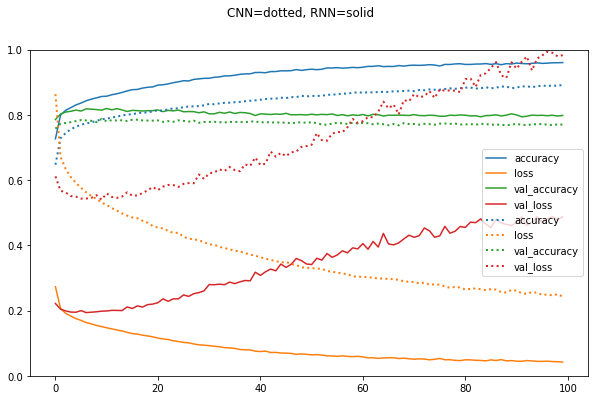

In [36]:
fig = plt.Figure(figsize=(10, 6))
fig.suptitle("CNN=dotted, RNN=solid")
ax = fig.subplots()
pd.DataFrame(rhistory).plot(ylim=[0, 1], ax=ax)
ax.set_prop_cycle(None)
pd.DataFrame(chistory).plot(ylim=[0, 1], ax=ax, linestyle="dotted", linewidth=2)
fig

In [40]:
cnn_top.evaluate(x_cnn_test, y_cnn_test)

132/132 [==============================] - 0s 2ms/step - loss: 1.0544 - accuracy: 0.7658


[1.0543959140777588, 0.7657807469367981]

In [41]:
rnn_top.evaluate(x_rnn_test, y_rnn_test)

13/13 [==============================] - 1s 7ms/step - loss: 0.4846 - slicewise_accuracy: 0.7992


[0.4846106767654419, 0.7992406487464905]

## End-To-End Models

In [37]:
cnn_model = Sequential()
cnn_model.add(backbone)
cnn_model.add(Dense(256, activation="relu"))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(5, activation="softmax"))

cnn_model.layers[0].trainable = False
cnn_model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])

In [39]:
cnn_model.fit(slice_gen, epochs=1)

642/642 [==============================] - 164s 255ms/step - loss: 0.5978 - accuracy: 0.7615


In [ ]:
test_gen = PhaseDataGenerator(data, "KAG", target_size=(224, 224), batch_size=2, shuffle=False)

In [ ]:
rnn_model.evaluate(test_gen)

In [ ]:
preds = rnn_model.predict(test_gen)

In [ ]:
preds = rnn_top.predict(x_rnn)

In [ ]:
labels = y_rnn

In [ ]:
def get_accuracy(preds, labels):
    total_slices = 0
    total_phases = 0
    correct_slices = 0
    correct_phases = 0

    for phase, slices in enumerate(preds):
        total_phases += 1
        correct_phase = True
        for slice, pred in enumerate(slices):
            label = labels[phase][slice]
            if label.sum() == 0:
                pass
            else:
                total_slices += 1
                if label.argmax() == pred.argmax():
                    correct_slices += 1
                else:
                    correct_phase = False
        if correct_phase:
            correct_phases += 1

    slice_accuracy = correct_slices / total_slices
    phase_accuracy = correct_phases / total_phases

    return slice_accuracy, phase_accuracy, total_slices

In [ ]:
slice_accuracy, phase_accuracy, ts = get_accuracy(preds, labels)
print("Slice accuracy:", slice_accuracy)
print("Phase accuracy:", phase_accuracy)